## **Framework  deep learning network SAR segmentation**

In [90]:
#Import the necessary libraries:
get_ipython().run_line_magic('env', 'SM_FRAMEWORK=tf.keras')
import random
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Input, Add,  Activation,add,LayerNormalization
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization,Concatenate,SeparableConv2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Dropout, Multiply
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, UpSampling3D
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, Conv2DTranspose
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet201, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

import warnings

K.clear_session()
warnings.filterwarnings("ignore")

env: SM_FRAMEWORK=tf.keras


## **Importing and preprocessing dataset**

In [91]:
#Load Data and Display

H,W,CH=[128,128,3]
image_dir = 'SAR/train/images/'
mask_dir = 'SAR/train/masks/'


In [92]:
#Loading------------------------------
Images = []
for file in tqdm(sorted(os.listdir(image_dir))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(image_dir + file, target_size=(H,W))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.
        Images.append(image)

Images = np.array(Images)

Masks = []
for file in tqdm(sorted(os.listdir(mask_dir))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(mask_dir +  file, target_size=(H,W), color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.
        Masks.append(image)

Masks = np.array(Masks)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:13<00:00, 39.98it/s]


In [103]:
# Split the dataset into training and validation sets
x = Images
y = Masks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("x_train shape:",x_train.shape)
print("y_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (447, 128, 128, 3)
y_test shape: (112, 128, 128, 3)
y_train shape: (447, 128, 128, 1)
y_test shape: (112, 128, 128, 1)


## **Plot some of SAR images**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.64it/s]


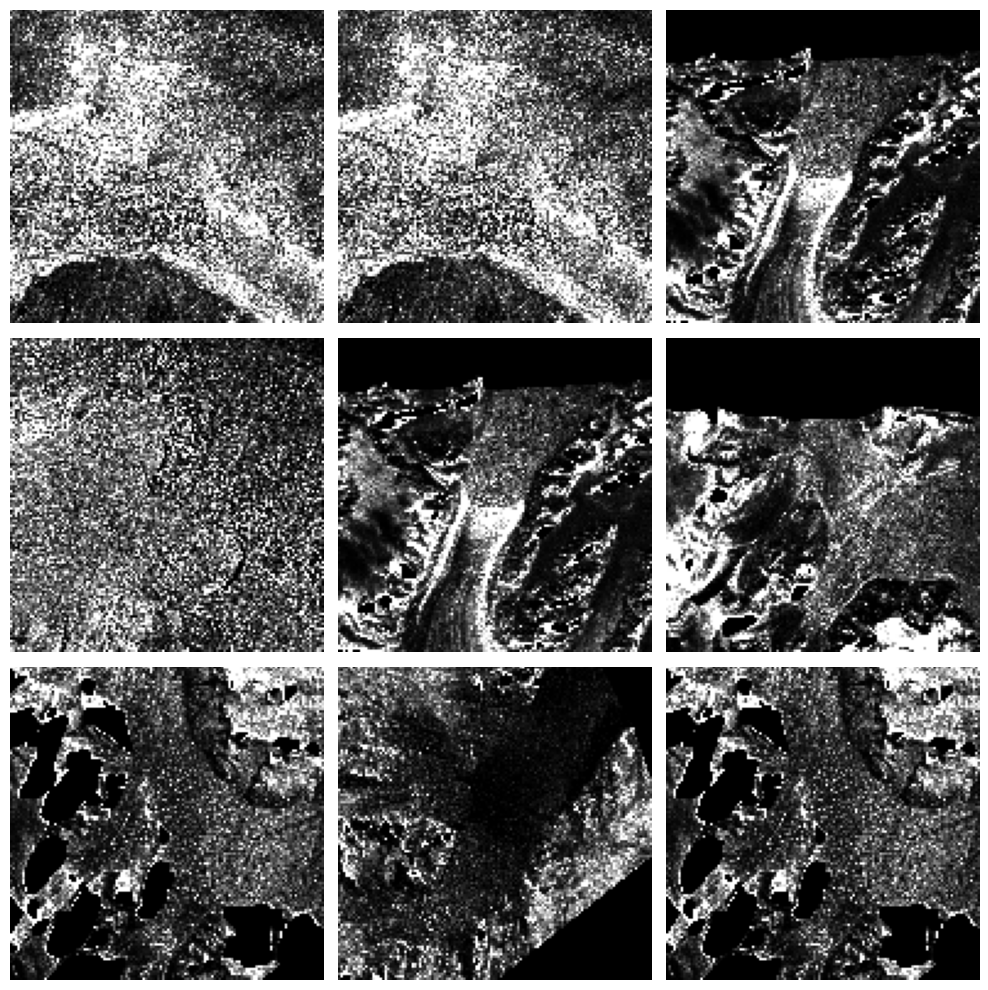

In [94]:
#Display---------------------
figure, axes = plt.subplots(8,2, figsize=(10,10))
indexes=[]
for i in tqdm(range(9)):
    index=random.randint(0,10)    
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[index],cmap='gray')
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 62.14it/s]


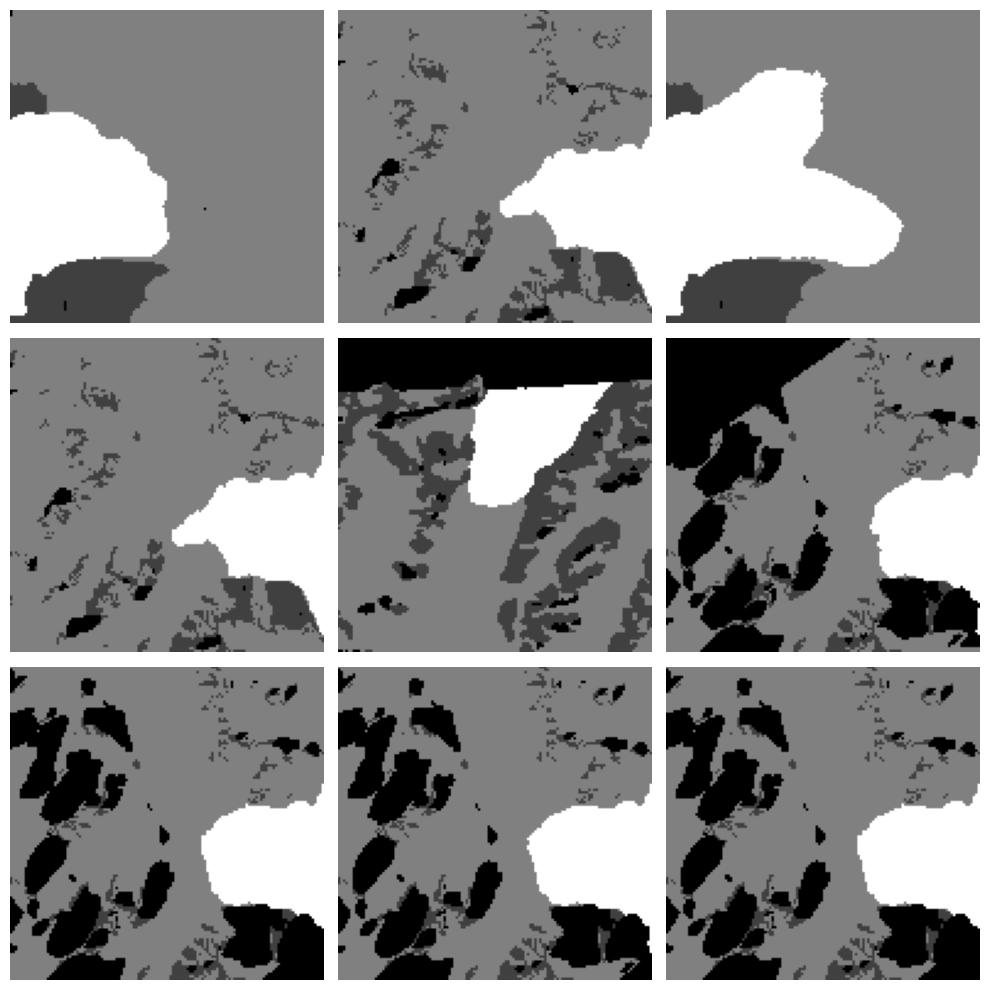

In [95]:
#Display---------------------
figure, axes = plt.subplots(8,2, figsize=(10,10))
indexes=[]
for i in tqdm(range(9)):
    index=random.randint(0,10)    
    plt.subplot(3,3,i+1)
    plt.imshow(y_train[index],cmap='gray')
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.28it/s]


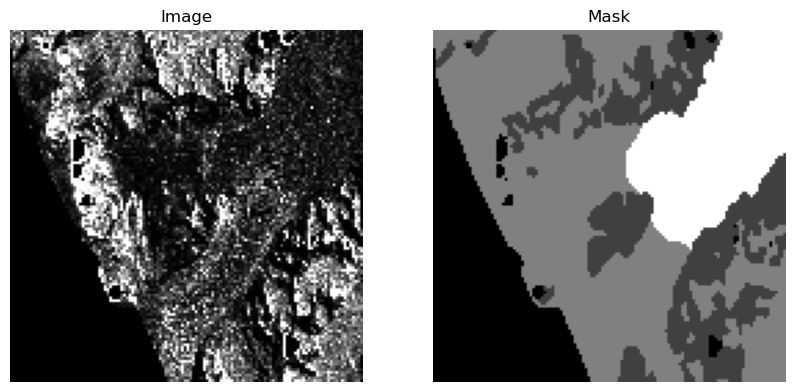

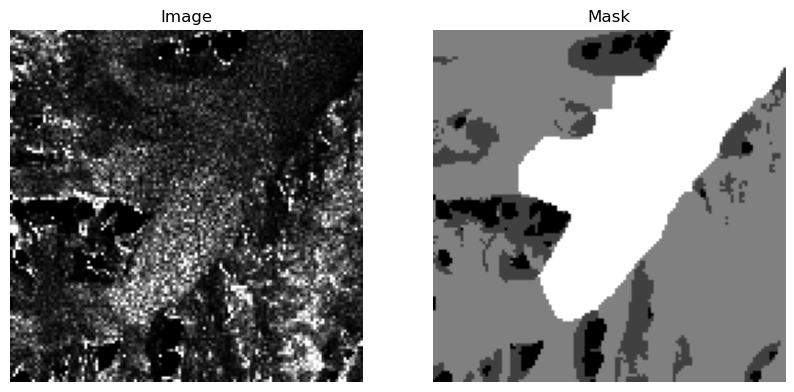

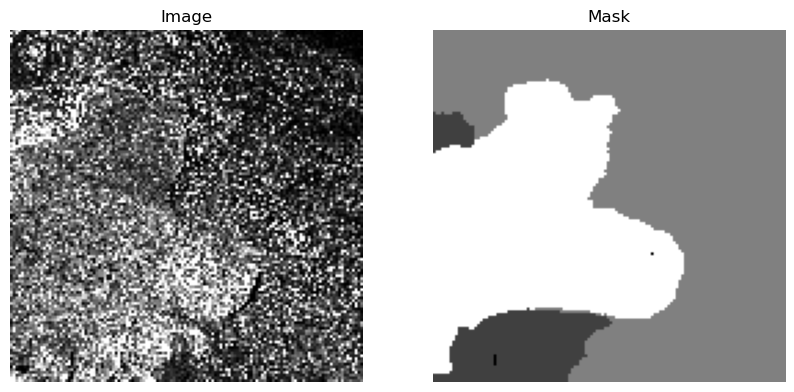

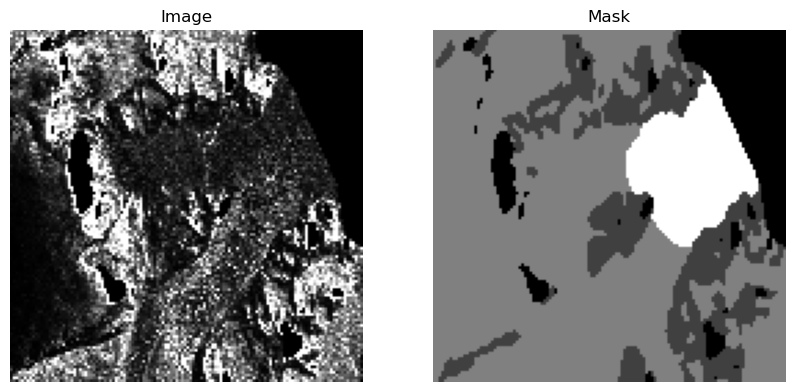

In [96]:
#Display test data
for i in tqdm(range(4)):
    idx = np.random.randint(0,80)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'black', fontsize = 12)
    plt.imshow(x_train[idx],cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Mask', color = 'black', fontsize = 12)
    plt.imshow(y_train[idx],cmap='gray')
    plt.axis('off')


## **Building CNN model architecture**

In [97]:
#DSNet
def DSARNet(nClasses, input_height, input_width):    
    img_input = Input(shape=(input_height, input_width, 3))    
    Encoder_Dense = DenseNet121( weights = 'imagenet',include_top = False,input_tensor = img_input) 
    Encoder = SeparableConv2D(filters = 1024,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding="same")(Encoder_Dense.output)
    
    Encoder = BatchNormalization()(Encoder)
    
    # Decoding
    Decoder = UpSampling2D(size = (2, 2))(Encoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool3_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 1024,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)
    
    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool2_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool1").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D( size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="conv1/bn").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)    
    Decoder = SeparableConv2D(filters = 64,kernel_size = (3, 3),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = SeparableConv2D(filters = nClasses,kernel_size = (1, 1),activation = 'relu',kernel_initializer='he_normal',
                              padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)    

    Predicted_Mask = Conv2D(filters = 1,kernel_size = 1,activation = 'sigmoid')(Decoder)        
    DSARNet_model = Model(inputs = img_input, outputs = Predicted_Mask)

    return DSARNet_model


# **Create model**

In [98]:
#Parameters
input_shape = (H, W, CH)
num_classes = 2

model=DSARNet(num_classes, H, W)

## **Loss functions**

In [99]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [100]:
#iou metric
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#jacard_coef
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## **Model compilation**

In [101]:
#Model compile-------
model.compile( optimizer='adam',loss=[bce_jaccard_loss,dice_loss,'binary_crossentropy'],metrics=['accuracy', jacard_coef, iou]) 
#'sparse_categorical_crossentropy'=class>2
#'binary_crossentropy' class=2
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 4, 4, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

                                                                                                  
 batch_normalization_1 (BatchNo  (None, 8, 8, 1024)  4096        ['separable_conv2d_1[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 16, 16, 1024  0          ['batch_normalization_1[0][0]']  
                                )                                                                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 16, 16, 1152  0           ['pool2_pool[0][0]',             
                                )                                 'up_sampling2d_1[0][0]']        
                                                                                                  
 separable

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.657009 to fit



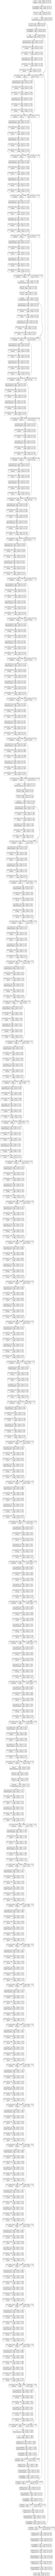

In [102]:
tf.keras.utils.plot_model(model, 'Model.png', show_shapes=True)


## **Model Training**

In [89]:
#Model Training
nepochs=1
nbatch_size=32
history = model.fit(x_train, y_train, epochs=nepochs, validation_data=(x_test, y_test),
                    batch_size=nbatch_size,verbose=1,shuffle=True,
                    max_queue_size=8,workers=1,use_multiprocessing=True,
                   )

Epoch 1/20
14/14 [==============================] - 159s 10s/step - loss: 1.2627 - accuracy: 0.0904 - jacard_coef: 0.3792 - iou: 0.3794 - val_loss: 1.3434 - val_accuracy: 0.0000e+00 - val_jacard_coef: 0.3471 - val_iou: 0.3473
Epoch 2/20
14/14 [==============================] - 129s 9s/step - loss: 1.2457 - accuracy: 0.0912 - jacard_coef: 0.3866 - iou: 0.3867 - val_loss: 1.3413 - val_accuracy: 0.0000e+00 - val_jacard_coef: 0.3494 - val_iou: 0.3496
Epoch 3/20
14/14 [==============================] - 119s 9s/step - loss: 1.2299 - accuracy: 0.0914 - jacard_coef: 0.3936 - iou: 0.3938 - val_loss: 1.3393 - val_accuracy: 0.0000e+00 - val_jacard_coef: 0.3518 - val_iou: 0.3520
Epoch 4/20
14/14 [==============================] - 118s 8s/step - loss: 1.2143 - accuracy: 0.0913 - jacard_coef: 0.4006 - iou: 0.4008 - val_loss: 1.3372 - val_accuracy: 0.0000e+00 - val_jacard_coef: 0.3544 - val_iou: 0.3546
Epoch 5/20
14/14 [==============================] - 119s 9s/step - loss: 1.1992 - accuracy: 0.0917 


KeyboardInterrupt



In [ ]:
df_result = pd.DataFrame(history.history)
df_result

## **Performance evaluation**

In [ ]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['training_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['accuracy'])
plt.title('change in training accuracy coefitient over epochs')
plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.show()
plt.tight_layout()

# Plotting jacard  accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jacard_coef'])
plt.title('change in jacard_coef coefitient over epochs')
plt.legend(['jacard_coef'])
plt.xlabel('epochs')
plt.ylabel('jacard_coef')
plt.show()
plt.tight_layout()

# Plotting iou accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['iou'])
plt.title('change in iou coefitient over epochs')
plt.legend(['iou'])
plt.xlabel('epochs')
plt.ylabel('iou')
plt.show()
plt.tight_layout()


## **Model Evaluation**

In [ ]:
# predict test images
predict_y = model.predict(x_test)

plt.figure(figsize=(15,15))
for i in range(0,9,3):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.title('High image')
    
    plt.subplot(4,3,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i])
    plt.title('Low image')
    
    plt.subplot(4,3,i+3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(predict_y[i])
    plt.title('Output by model')

plt.show()

## **Model predictions**

In [ ]:
# Creating predictions on our test set-----------------
predictions = model.predict(x_test)

In [ ]:
# create predictes mask--------------
def create_mask(predictions,input_shape=(W,H,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask


In [ ]:
# Ploting results for one image----------------

def plot_results_for_one_sample(sample_index):    
    mask =predictions[sample_index] #create_mask(predictions[sample_index])   for gray-scale
    fig = plt.figure(figsize=(20,20))
    #image-------------------
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #mask-----------
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index],cmap='gray')
    plt.axis('off')
    plt.grid(None)
    #Predicted mask------------
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.grid(None)
    #Segment---------------
    fig.add_subplot(1,4,4)
    plt.title("Segment image")
    plt.imshow(x_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()    
plt.show()

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(1)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(6)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(10)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(14)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(20)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(25)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(30)

## **Make predictions**

In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
ax[0].imshow(x_train[ix])
ax[0].axis('off')
ax[0].set_title('Image')

ax[1].imshow(y_train[ix])
ax[1].axis('off')
ax[1].set_title('Mask')

ax[2].imshow(np.squeeze(preds_train_t[ix]))
ax[2].axis('off')
ax[2].set_title('Predicted mask')

plt.show()